# Calibration on CIFAR-10

In [1]:
import sys
sys.path.append("./../")

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from pretrained.CIFAR10.PyTorch_CIFAR10.cifar10_models import vgg
from pretrained.MedMNIST.evaluation import ECE, MCE

/home/rajv1/.conda/envs/bayes/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Evalution and calibration

In [3]:
from scipy.optimize import minimize 
from sklearn.metrics import log_loss, brier_score_loss

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Parameters:
        x (numpy.ndarray): array containing m samples with n-dimensions (m,n)
    Returns:
        x_softmax (numpy.ndarray) softmaxed values for initial (m,n) array
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=1)

class TemperatureScaling():
    
    def __init__(self, temp = 1, maxiter = 50, solver = "BFGS"):
        """
        Initialize class
        
        Params:
            temp (float): starting temperature, default 1
            maxiter (int): maximum iterations done by optimizer, however 8 iterations have been maximum.
        """
        self.temp = temp
        self.maxiter = maxiter
        self.solver = solver
    
    def _loss_fun(self, x, probs, true):
        # Calculates the loss using log-loss (cross-entropy loss)
        scaled_probs = self.predict(probs, x)    
        loss = log_loss(y_true=true, y_pred=scaled_probs)
        return loss
    
    # Find the temperature
    def fit(self, logits, true):
        """
        Trains the model and finds optimal temperature
        
        Params:
            logits: the output from neural network for each class (shape [samples, classes])
            true: one-hot-encoding of true labels.
            
        Returns:
            the results of optimizer after minimizing is finished.
        """
        
        true = true.flatten() # Flatten y_val
        opt = minimize(self._loss_fun, x0 = 1, args=(logits, true), options={'maxiter':self.maxiter}, method = self.solver)
        self.temp = opt.x[0]
        
        return opt
        
    def predict(self, logits, temp = None):
        """
        Scales logits based on the temperature and returns calibrated probabilities
        
        Params:
            logits: logits values of data (output from neural network) for each class (shape [samples, classes])
            temp: if not set use temperatures find by model or previously set.
            
        Returns:
            calibrated probabilities (nd.array with shape [samples, classes])
        """
        
        if not temp:
            return softmax(logits/self.temp)
        else:
            return softmax(logits/temp)

In [5]:
from sklearn.metrics import log_loss, brier_score_loss
import sklearn.metrics as metrics


def evaluate(probs, y_true, verbose = False, normalize = False, bins = 15):
    """
    Evaluate model using various scoring measures: Error Rate, ECE, MCE, NLL, Brier Score
    
    Params:
        probs: a list containing probabilities for all the classes with a shape of (samples, classes)
        y_true: a list containing the actual class labels
        verbose: (bool) are the scores printed out. (default = False)
        normalize: (bool) in case of 1-vs-K calibration, the probabilities need to be normalized.
        bins: (int) - into how many bins are probabilities divided (default = 15)
        
    Returns:
        (error, ece, mce, loss, brier), returns various scoring measures
    """
    
    preds = np.argmax(probs, axis=1)  # Take maximum confidence as prediction
    
    if normalize:
        confs = np.max(probs, axis=1)/np.sum(probs, axis=1)
        # Check if everything below or equal to 1?
    else:
        confs = np.max(probs, axis=1)  # Take only maximum confidence
    
    accuracy = metrics.accuracy_score(y_true, preds) * 100
    error = 100 - accuracy
    
        # Calculate ECE
    ece = ECE(confs, preds, y_true, bin_size = 1/bins)
    # Calculate MCE
    mce = MCE(confs, preds, y_true, bin_size = 1/bins)
    
    loss = log_loss(y_true=y_true, y_pred=probs)
    
    y_prob_true = np.array([probs[i, idx] for i, idx in enumerate(y_true)])  # Probability of positive class
#     brier = brier_score_loss(y_true=y_true, y_prob=y_prob_true)  # Brier Score (MSE)
    
    if verbose:
        print("Accuracy:", accuracy)
        print("Error:", error)
        print("ECE:", ece)
        print("MCE:", mce)
        print("Loss:", loss)
#         print("brier:", brier)
    
    return (error, ece, mce, loss)

In [7]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

dataset = CIFAR10(root="./../data/", train=False, transform=transform, download=False)

dataloader = DataLoader(dataset, batch_size=1024, num_workers=2)

## VGG

In [12]:
const_bnn_prior_parameters = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type": "Reparameterization",  # Flipout or Reparameterization
    "moped_enable": True,  # initialize mu/sigma from the dnn weights
    "moped_delta": 0.20,
}

model = vgg.vgg11_bn(pretrained=True)
dnn_to_bnn(model, const_bnn_prior_parameters)
model.load_state_dict(torch.load("./cifar10-vgg11bn-moped-10e-v1.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
# get models predictions
def get_bnn_model_predictions(model, dataloader, device):
    mc_samples = 32
    output_list = []
    labels_list = []
    
    model.eval()
    with torch.no_grad():
        for data, target in dataloader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            else:
                data, target = data.cpu(), target.cpu()
            output_mc = []
            for mc_run in range(mc_samples):
                output = model.forward(data)
                output_mc.append(output)
            output_ = torch.stack(output_mc).mean(dim=0)
            output_list.append(output_)
            labels_list.append(target)

        output = torch.cat(output_list)
        labels = torch.cat(labels_list)

    logits = output.cpu().numpy()
    labels = labels.cpu().numpy().reshape(-1, 1).astype(int)

    return logits, labels

logits, labels = get_bnn_model_predictions(model, dataloader, 'cpu')

In [18]:
uncal_err, uncalib_ece, uncalib_mce, uncalib_loss = evaluate(softmax(logits), labels, verbose=True)

Accuracy: 95.17
Error: 4.829999999999998
ECE: 0.017794682222604736
MCE: 0.35466119647026056
Loss: 0.1541244813848251


In [19]:
scores = softmax(logits)

#### Temparature scaling

In [20]:
TScaler = TemperatureScaling()
TScaler.fit(logits, labels)
calib_yscores = TScaler.predict(logits)

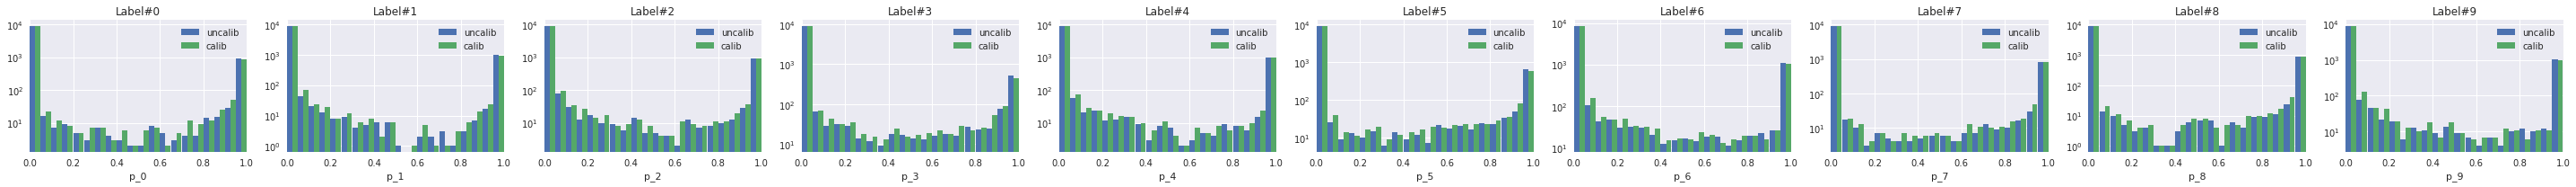

In [21]:
K = scores.shape[1]

# fig, ax = plt.subplots(K, 1, figsize=(12, K*3))
fig, ax = plt.subplots(1, K, figsize=(K*4, 3))


for i in range(K):
       
    # uncalibrated
    _ax = ax[i]
    # Get labels
    yscore = scores[:, i]
    hist, bin_edges = np.histogram(yscore, bins=20, range=(0.0, 1.0))
    _ax.bar(bin_edges[:-1], hist, align='edge', width=1/(2*20), label="uncalib")
    _ax.set_xlim(0, 1)
    
    
    # calibrated
    yscore = calib_yscores[:, i]
    # plot histogram of scores
    hist, bin_edges = np.histogram(yscore, bins=20, range=(0.0, 1.0))
    _ax.bar(bin_edges[:-1] + 1/40, hist, align='edge', width=1/(2*20+1), label='calib')
    _ax.set_xlim(0, 1)
    _ax.set_yscale('log')
    _ax.legend()
    _ax.set_title("Label#{}".format(i))
    _ax.set_xlabel("p_{}".format(i))
    
plt.tight_layout()

In [22]:
cal_err, calib_ece, calib_mce, calib_loss = evaluate(calib_yscores, labels, verbose=True)

Accuracy: 95.17
Error: 4.829999999999998
ECE: 0.009834006085991817
MCE: 0.44016898423433304
Loss: 0.14900847200379294


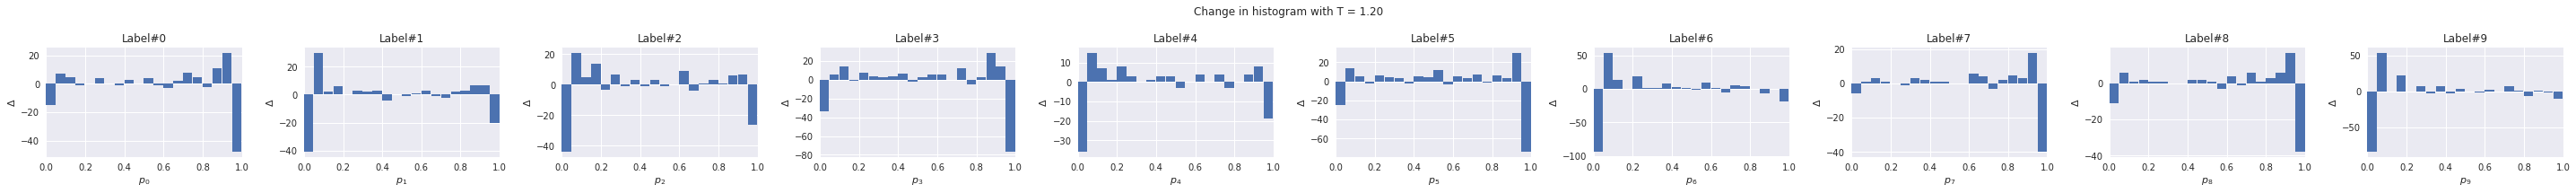

In [23]:
K = scores.shape[1]

fig, ax = plt.subplots(1, K, figsize=(K*4, 3))


for i in range(K):
       
    # uncalibrated
    _ax = ax[i]
    # Get labels
    yscore1 = scores[:, i]
    hist1, bin_edges1 = np.histogram(yscore1, bins=20, range=(0.0, 1.0))

    # calibrated
    yscore2 = calib_yscores[:, i]
    # plot histogram of scores
    hist2, bin_edges2 = np.histogram(yscore2, bins=20, range=(0.0, 1.0))
    
    _ax.bar(bin_edges[:-1], 
            hist2 - hist1, align='edge', 
            width=1/(20+1))
    _ax.set_xlim(0, 1)
    _ax.set_ylabel("$\\Delta$")
    _ax.set_title("Label#{}".format(i))
    _ax.set_xlabel("$p_{}$".format(i))
    
plt.suptitle("Change in histogram with T = {:.2f}".format(TScaler.temp))
plt.tight_layout()

## Plot ECE, MCE and loss for a range of temparatures

In [39]:
T_list = np.arange(0.20, 2.0+0.01, 0.1)

In [40]:
ece_list = []
mce_list = []
loss_list = []

for T_val in T_list:
    probs = TScaler.predict(logits, temp=T_val)
    _err, _ece, _mce, _loss = evaluate(probs, labels, verbose=False)
    
    ece_list.append(_ece)
    mce_list.append(_mce)
    loss_list.append(_loss)

Text(0.5, 1.0, 'Loss')

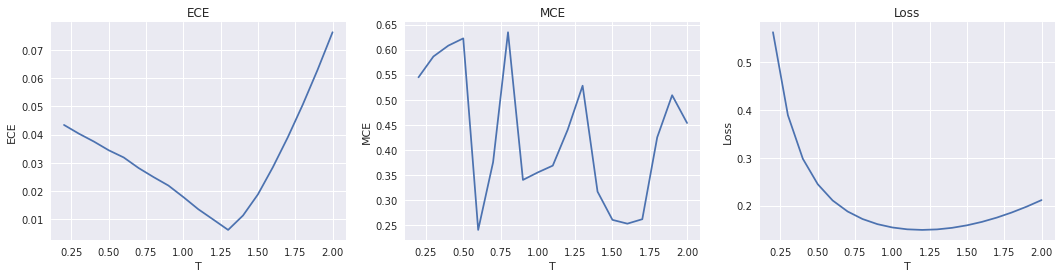

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(3*6, 4))

ax[0].plot(T_list, ece_list)
ax[0].set_xlabel('T')
ax[0].set_ylabel('ECE')
ax[0].set_title('ECE')

ax[1].plot(T_list, mce_list)
ax[1].set_xlabel('T')
ax[1].set_ylabel('MCE')
ax[1].set_title('MCE')

ax[2].plot(T_list, loss_list)
ax[2].set_xlabel('T')
ax[2].set_ylabel('Loss')
ax[2].set_title('Loss')

## MAP Model analysis

In [42]:
model = vgg.vgg11_bn(pretrained=True)

In [43]:
def get_model_predictions(model, dataloader, device):
    model.eval()

    logits = torch.tensor([])
    targets = torch.tensor([])
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)

            logits = torch.cat((logits, outputs.cpu()), 0)
            targets = torch.cat((targets, labels), 0)

    logits = logits.numpy()
    labels = targets.numpy().reshape(-1, 1).astype(int)

    return logits, labels

In [44]:
logits, labels = get_bnn_model_predictions(model, dataloader, 'cpu')

In [45]:
uncal_err, uncalib_ece, uncalib_mce, uncalib_loss = evaluate(softmax(logits), labels, verbose=True)

Accuracy: 92.39
Error: 7.609999999999999
ECE: 0.015016079756617595
MCE: 0.8040124326944351
Loss: 0.24998825050200102


In [46]:
ece_list = []
mce_list = []
loss_list = []

for T_val in T_list:
    probs = TScaler.predict(logits, temp=T_val)
    _err, _ece, _mce, _loss = evaluate(probs, labels, verbose=False)
    
    ece_list.append(_ece)
    mce_list.append(_mce)
    loss_list.append(_loss)

Text(0.5, 1.0, 'Loss')

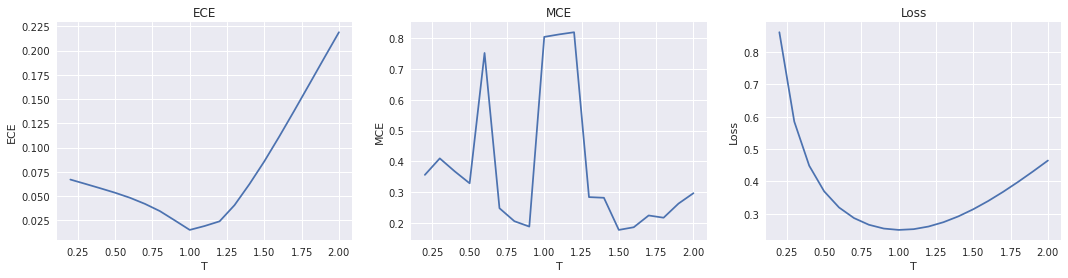

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(3*6, 4))

ax[0].plot(T_list, ece_list)
ax[0].set_xlabel('T')
ax[0].set_ylabel('ECE')
ax[0].set_title('ECE')

ax[1].plot(T_list, mce_list)
ax[1].set_xlabel('T')
ax[1].set_ylabel('MCE')
ax[1].set_title('MCE')

ax[2].plot(T_list, loss_list)
ax[2].set_xlabel('T')
ax[2].set_ylabel('Loss')
ax[2].set_title('Loss')